## Task 3: Customer Segmentation / Clustering

Perform customer segmentation using clustering techniques. Use both profile information (from Customers.csv) and transaction information (from Transactions.csv).
- You have the flexibility to choose any clustering algorithm and any number of clusters in between(2 and 10)
- Calculate clustering metrics, including the DB Index(Evaluation will be done on this).
- Visualise your clusters using relevant plots.

In [23]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
df_customers = pd.read_csv("/home/dispers/PRACHI/Customers.csv")
df_products = pd.read_csv("/home/dispers/PRACHI/Products.csv")
df_txns = pd.read_csv("/home/dispers/PRACHI/Transactions.csv")

df_merged = pd.merge(df_txns, df_products, how = "left", on = ["ProductID","Price"])
df_merged = pd.merge(df_merged, df_customers, how = "left", on = "CustomerID")

As the regions are of character/text data type, working with them directly can cause an issue. Thus, we use one-hot encoding to convert them to boolean values which are easier to process and compare for the model.

In [25]:
df_merged = pd.get_dummies(df_merged, columns=['Region'])

Every customer makes transactions in different months of the year. Extracting month from the transaction dates can help us analyze the customer's behaviour according to the season. It is possible that a certain type/category of product is purchased more in a certain month of the year. 

The same goes for sign-up month.

In [26]:
df_merged['SignupMonth'] = pd.to_datetime(df_merged['SignupDate']).dt.month
df_merged['TransactionMonth'] = pd.to_datetime(df_merged['TransactionDate']).dt.month

As we need to develop a clustering model based on customers' personal information and their transaction histories, we will make a customer profile for every consumer.

In [27]:
cust_profiles = df_merged.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID':'count',
    'Quantity':'sum',
    'TransactionMonth': lambda x: x.mode()[0],    
    'Region_Asia': 'first',
    'Region_Europe': 'first',
    'Region_North America': 'first',
    'Region_South America': 'first',
    'Category': lambda x: ','.join(x),  
}).reset_index()

cust_profiles['AvgTxnValue'] = cust_profiles['TotalValue'] / cust_profiles['TransactionID']
cust_profiles = cust_profiles.rename(columns={"TransactionID":"TotalTxns"})
cust_profiles

,CustomerID,TotalValue,TotalTxns,Quantity,TransactionMonth,Region_Asia,Region_Europe,Region_North America,Region_South America,Category,AvgTxnValue
0,C0001,3354.52,5,12,1,False,False,False,True,"Books,Home Decor,Electronics,Electronics,Elect...",670.904000
1,C0002,1862.74,4,10,2,True,False,False,False,"Home Decor,Home Decor,Clothing,Clothing",465.685000
2,C0003,2725.38,4,14,6,False,False,False,True,"Home Decor,Home Decor,Clothing,Electronics",681.345000
3,C0004,5354.88,8,23,12,False,False,False,True,"Books,Home Decor,Home Decor,Home Decor,Books,B...",669.360000
4,C0005,2034.24,3,7,3,True,False,False,False,"Home Decor,Electronics,Electronics",678.080000
...,...,...,...,...,...,...,...,...,...,...,...
194,C0196,4982.88,4,12,8,False,True,False,False,"Books,Clothing,Home Decor,Home Decor",1245.720000
195,C0197,1928.65,3,9,1,False,True,False,False,"Home Decor,Electronics,Electronics",642.883333
196,C0198,931.83,2,3,9,False,True,False,False,"Electronics,Clothing",465.915000
197,C0199,1979.28,4,9,8,False,True,False,False,"Electronics,Home Decor,Home Decor,Electronics",494.820000


As categories appear as a text as well, we need to perform one-hot encoding as earlier.

As the ranges of different columns vary greatly (for example Quantity and TotalValue), we will use the MinMaxScaler to scale the values in the range 0-1 while still accounting for their actual distance from the original value scale.

In [28]:
categories_encoded = cust_profiles['Category'].str.get_dummies(sep=',')
cust_profiles = pd.concat([cust_profiles, categories_encoded], axis=1).drop(columns=['Category'])

In [29]:
scaler = MinMaxScaler()
scaled_cust_profiles = scaler.fit_transform(cust_profiles.iloc[:, 1:])
scaled_cust_profiles

array([[0.30894178, 0.4       , 0.35483871, ..., 0.        , 1.        ,
        1.        ],
       [0.16809501, 0.3       , 0.29032258, ..., 1.        , 0.        ,
        1.        ],
       [0.24954138, 0.3       , 0.41935484, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.08020292, 0.1       , 0.06451613, ..., 1.        , 1.        ,
        0.        ],
       [0.17909816, 0.3       , 0.25806452, ..., 0.        , 1.        ,
        1.        ],
       [0.44150834, 0.4       , 0.48387097, ..., 1.        , 1.        ,
        1.        ]], shape=(199, 13))

Best number of clusters based on DB score: 7


Clustering Metrics Scores:
Clusters: 2, DB Index: 1.972, Silhouette Score: 0.163, Inertia: 300.601
Clusters: 3, DB Index: 1.791, Silhouette Score: 0.225, Inertia: 256.898
Clusters: 4, DB Index: 1.420, Silhouette Score: 0.303, Inertia: 205.996
Clusters: 5, DB Index: 1.696, Silhouette Score: 0.251, Inertia: 195.338
Clusters: 6, DB Index: 1.608, Silhouette Score: 0.256, Inertia: 180.965
Clusters: 7, DB Index: 1.419, Silhouette Score: 0.259, Inertia: 169.805
Clusters: 8, DB Index: 1.521, Silhouette Score: 0.244, Inertia: 160.629
Clusters: 9, DB Index: 1.476, Silhouette Score: 0.247, Inertia: 152.569


Metrics for 7 Number of Clusters:
Davies-Bouldin Index: 1.42
Silhouette Score: 0.26


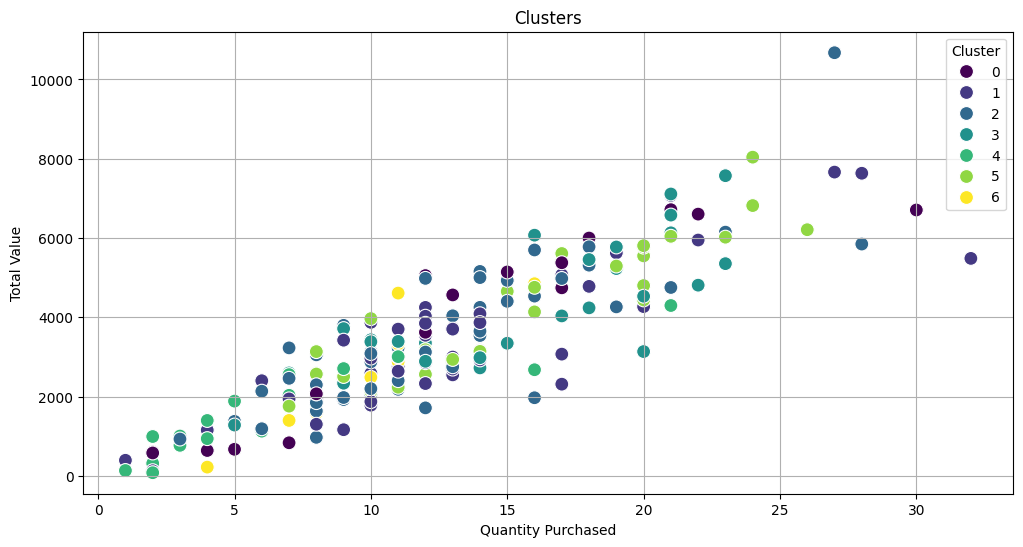

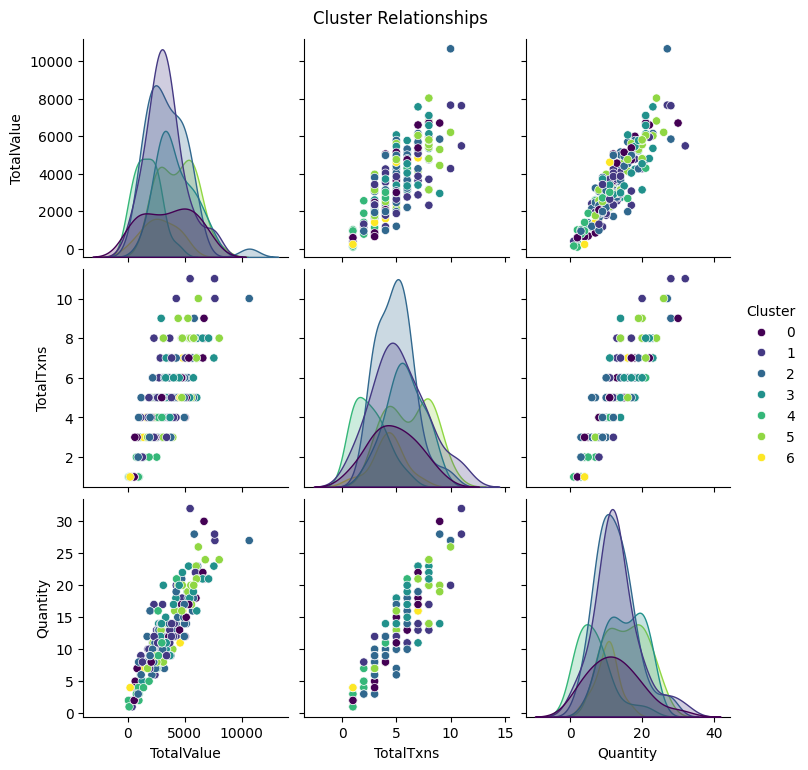

In [30]:
# Metrics
db_scores = []
silhouette_scores = []
inertia_values = []

# Defining the optimal range of clusters
num_clusters = range(2, 10)

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=1)
    labels = kmeans.fit_predict(scaled_cust_profiles)

    # Evaluating the metrics
    db_index = davies_bouldin_score(scaled_cust_profiles, labels)
    silhouette_avg = silhouette_score(scaled_cust_profiles, labels)
    inertia = kmeans.inertia_
    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)
    inertia_values.append(inertia)


# Best DB score - the least one
best_k = num_clusters[np.argmin(db_scores)]
print(f"Best number of clusters based on DB score: {best_k}")

print("\n")
print("Clustering Metrics Scores:")
for clus_number, dbscore, silscore, inertiascore in zip(num_clusters, db_scores, silhouette_scores, inertia_values):
    print(f"Clusters: {clus_number}, DB Index: {dbscore:.3f}, Silhouette Score: {silscore:.3f}, Inertia: {inertiascore:.3f}")


# Using the best number of clusters for KMeans
kmeans_best = KMeans(n_clusters=best_k, random_state=1)
cust_profiles['Cluster'] = kmeans_best.fit_predict(scaled_cust_profiles)

best_db_index = davies_bouldin_score(scaled_cust_profiles, cust_profiles['Cluster'])
best_sil_score = silhouette_score(scaled_cust_profiles, cust_profiles['Cluster'])

print("\n")
print(f"Metrics for {best_k} Number of Clusters:")
print(f"Davies-Bouldin Index: {best_db_index:.2f}")
print(f"Silhouette Score: {best_sil_score:.2f}")


plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=cust_profiles['Quantity'],
    y=cust_profiles['TotalValue'],
    hue=cust_profiles['Cluster'],
    palette='viridis',
    s=100
)
plt.title('Clusters')
plt.xlabel('Quantity Purchased')
plt.ylabel('Total Value')
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()

# Pairplot for comparing different features
sns.pairplot(
    cust_profiles,
    vars=['TotalValue', 'TotalTxns', 'Quantity'],
    hue='Cluster',
    palette='viridis'
)
plt.suptitle('Cluster Relationships', y=1.02)
plt.show()